In [1]:
import sys
import os
sys.path.insert(0, '/Users/james/Desktop/DRL_Hedging/')
import gymnasium as gym
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from financial_models.asset_price_models import GBM
from financial_models.option_price_models import BSM

from hedging_env_gymnasium_a import HedgingEnv
from Utils import NormalizeObservationWrapper

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy


seed = 345
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:

mu = 0
D = 5
T = 10
num_steps = T*D
s_0 = 100
strike_price = s_0
sigma = 0.15
r = 0
trading_cost_para=0.01
L=100

apm = GBM(mu=mu, dt=1/(252*D), s_0=s_0, sigma=sigma)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=r, volatility=sigma, T=T/252, dt=1/(252*D))
env = HedgingEnv(asset_price_model=apm, D=D, T=T, num_steps=num_steps, trading_cost_para=trading_cost_para,r=r,
                 L=L, strike_price=strike_price, int_holdings=False, initial_holding=0, mode="RA",
                 option_price_model=opm)

env_id = "hedging_env_gymnasium"

In [3]:
normalized_env = NormalizeObservationWrapper(env)
training_env = Monitor(normalized_env)

In [4]:


# Callback for plotting
class PlottingCallback(BaseCallback):
    def __init__(self, check_freq: int, verbose=1):
        super(PlottingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []
        self.steps = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            mean_reward, _ = evaluate_policy(self.model, self.training_env, n_eval_episodes=100)
            self.rewards.append(mean_reward)
            self.steps.append(self.n_calls)
        return True

    def _on_training_end(self) -> None:
        plt.plot(self.steps, self.rewards)
        plt.xlabel('Steps')
        plt.ylabel('Average Reward')
        plt.title('Training Progress')
        plt.show()



Using cpu device
Wrapping the env in a DummyVecEnv.


/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 50        |
|    ep_rew_mean     | -3.21e+04 |
| time/              |           |
|    fps             | 222       |
|    iterations      | 1         |
|    time_elapsed    | 9         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | -3.14e+04    |
| time/                   |              |
|    fps                  | 223          |
|    iterations           | 2            |
|    time_elapsed         | 18           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 1.939945e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.3          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -1.07e-06    |
|    

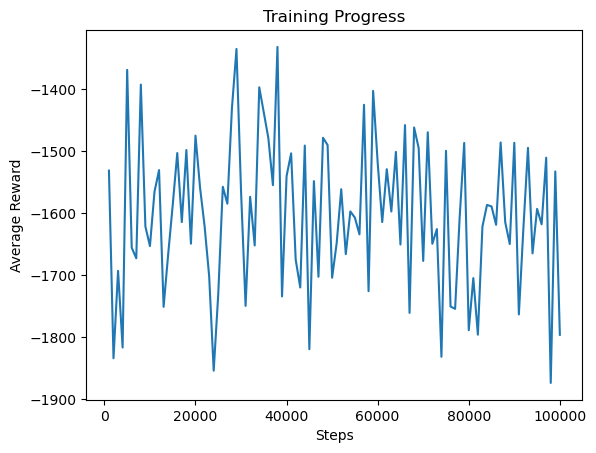

In [5]:
# Define the directory to save the models
save_path = "./trained_models"
if not os.path.exists(save_path):
    os.makedirs(save_path)

policy_kwargs = dict(activation_fn=nn.ReLU,
                     net_arch=dict(pi=[64,64,64], vf=[64,64,64]))

model_ppo = PPO("MlpPolicy",
                training_env,
                verbose=1, 
                gamma=0.9,
                clip_range=0.3,
                learning_rate=1e-4, 
                batch_size=1024,
                policy_kwargs=policy_kwargs)


checkpoint_callback_ppo = CheckpointCallback(save_freq=1000, save_path=save_path, name_prefix="ppo_model")
plotting_callback = PlottingCallback(check_freq=1000)

total_timesteps = 1e5
model_ppo.learn(total_timesteps=total_timesteps, callback=[checkpoint_callback_ppo, plotting_callback])
model_ppo.save(f"{save_path}/ppo_final")